# Comparing survival curves

## Example from the SNO18 poster presented by VAXIMM in PD-L1lo and PD-L1hi groups.

In [2]:
import lifelines
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter

In [3]:
data=pd.DataFrame(
    {
        'T':         [111, 861,  778,  839,  227, 250, 161, 566 ],
        'E':         [1,   0,    1,    0,    1,   1,   1,   0   ],
        'pat':       [2601,2702, 2704, 2605, 2706,2607,2708,2714],
        'PD-L1_incr':[True,False,False,False,True,True,True,True]
    }
)

### Dealing with dates

```{python}
from datetime import datetime

data['Censored'] = data['Death'].notnull().astype(np.int)

data['Days'] = np.where(
	data['Censored'] == 1,
	data['Death']  - data['D0'], 
	datetime.now() - data['D0']) #calculate time from D0

# also see the helper function to lifelines format
from lifelines.utils import datetimes_to_durations
start_date= ['2013-10-10 0:00:00', '2013-10-09', '2013-10-10']
end_date = ['2013-10-13', '2013-10-10', None]

T, E = datetimes_to_durations(
	start_date,
	end_date, 
	fill_date='2013-10-15')

kmf_init = KaplanMeierFitter()
kmf_init.fit(T, E)

# fitting own data
kmf_init.fit(data_all['Days'].dt.days, data_all['Censored'])
```

In [4]:
data

,T,E,pat,PD-L1_incr
0,111,1,2601,True
1,861,0,2702,False
2,778,1,2704,False
3,839,0,2605,False
4,227,1,2706,True
5,250,1,2607,True
6,161,1,2708,True
7,566,0,2714,True


### Fit the KaplanMeierFitter object and visualize

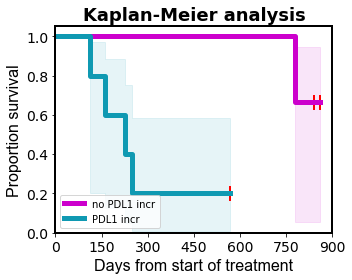

In [5]:
ix = data['PD-L1_incr'] == True

kmf_PDL1 = KaplanMeierFitter()

plt.rcParams["figure.figsize"] = (5,4)

kmf_PDL1.fit(
    durations=data['T'][~ix],
    event_observed=data['E'][~ix],
    label='no PDL1 incr',
)
ax=kmf_PDL1.plot(   # equivalent to kmf.plot_survival_function() or kmf.survival_function_.plot()
    #legend=None,
    show_censors=True,
    ci_alpha=.1,
    lw=5,
    c="#CC00CC",
    censor_styles={
        'marker':'|',
        'ms': 15,
        'mew':2,
        'markerfacecolor':'red', 
        'markeredgecolor':'red'
    }
)

kmf_PDL1.fit(
    data['T'][ix],
    data['E'][ix],
    label='PDL1 incr',
)

kmf_PDL1.plot(
    ax=ax,
    #legend=None,
    show_censors=True,
    ci_alpha=.1,
    lw=5,
    c="#0F99B2",
    censor_styles={
        'marker':'|',
        'ms': 15,
        'mew':2,
        'markerfacecolor':'red', 
        'markeredgecolor':'red'
    },
)

plt.xlim([0, 900])
plt.xticks([0,150, 300, 450, 600, 750, 900], fontsize=14)
plt.xlabel(
    'Days from start of treatment',
    fontdict={'fontname':'arial','size': 16})

plt.ylim([0,1.05])
plt.yticks(fontsize=14)
plt.ylabel('Proportion survival', fontdict={'fontname':'arial', 'size': 16})

plt.title('Kaplan-Meier analysis', fontdict={'size': 18, 'weight': 'bold'})


plt.setp(ax.spines.values(), linewidth=2) # contour of the graph
plt.tight_layout()
#plt.savefig('survival_pdl1.svg');

# possible to generate a Plotly plot using the .mpl_to_plotly() method,
# see https://plot.ly/ipython-notebooks/survival-analysis-r-vs-python/

### Playing with the fitter

In [6]:
print("Median survival time for PDL1 group:", kmf_PDL1.median_survival_time_)
print(kmf_PDL1.survival_function_) # Series returned

# predictions
day=200
print(f"Survival prediction in group '{kmf_PDL1._label}' at day {day}: {kmf_PDL1.predict(day):.1f}")

Median survival time for PDL1 group: 227.0
          PDL1 incr
timeline           
0.0             1.0
111.0           0.8
161.0           0.6
227.0           0.4
250.0           0.2
566.0           0.2
Survival prediction in group 'PDL1 incr' at day 200: 0.6


### Non-parametric testing

- Non-parametric = no assumption about the shape (not 'smooth')
- Parameteric = assumption about shape described w/ limited set of params

The Log-rank hypothesis tests the H0: $S_A(t)=S_B(t)$.

For Log-rank test betweenn more than 2 groups use pairwise_logrank_test() or multivariate_logrank_test()

In [7]:
from lifelines.statistics import logrank_test
results = logrank_test(
    durations_A=data['T'][ix],
    durations_B=data['T'][~ix],
    event_observed_A=data['E'][ix],
    event_observed_B=data['E'][~ix],
    alpha=.95)

results.print_summary(style='ascii')
#results.p_value
#results.test_statistic

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.74 0.05      4.23


## Example from the book

In [38]:
data=pd.DataFrame(
    {
        'T':   [2,6,12,54,56,68,89,96,96,125,128,131,140,141,143,145,146,148,162,168,173,181,
                2,3,4,7,10,22,28,29,32,37,40,41,54,61,63,71,127,140,146,158,167,182],
        'E':   [1,1,1,1,0,1,1,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,
                1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0],
        'PRED':[True]*22 + [False]*22,
    }
)

In [39]:
data.head()

,T,E,PRED
0,2,1,True
1,6,1,True
2,12,1,True
3,54,1,True
4,56,0,True


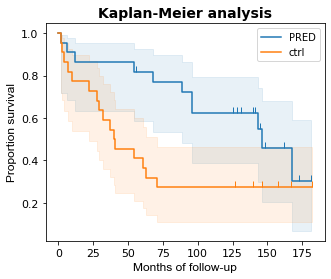

In [40]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

# Mask for prednisolone treatment
pred = (data['PRED'])

# Fit to new treatment and plot survival function
kmf.fit(
    data[pred]['T'],
    data[pred]['E'],
    label='PRED'
)

# visualizing group differences side-by-side
ax = plt.subplot(111)
kmf.plot_survival_function(
    show_censors=True,
    ci_alpha=.1,
    censor_styles={'marker':2, 'ms':6}, # tickup
    ax=ax)
# Fit to old treatment and plot survival function
kmf.fit(data[~pred]['T'], data[~pred]['E'], label='ctrl')
kmf.plot_survival_function(
    show_censors=True,
    ci_alpha=.1,
    censor_styles={'marker':2, 'ms':6}, # tickup
    ax=ax)

plt.xticks(fontsize=11)
plt.xlabel('Months of follow-up', fontdict={'fontname':'arial','size': 12})

plt.yticks(fontsize=11)
plt.ylabel('Proportion survival', fontdict={'fontname':'arial', 'size': 12})

plt.title('Kaplan-Meier analysis', fontdict={'size': 14, 'weight': 'bold'});

In [41]:
# getting the individual CI
kmf.confidence_interval_[:3]

,ctrl_lower_0.95,ctrl_upper_0.95
0.0,1.000000,1.000000
2.0,0.718703,0.993470
3.0,0.682979,0.976457


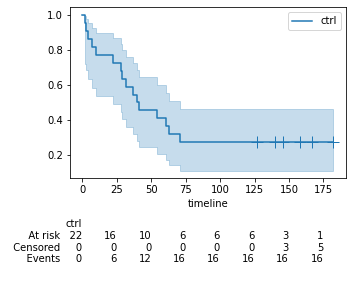

In [42]:
kmf.plot_survival_function(show_censors=True, at_risk_counts=True)
plt.tight_layout()

Both curves start at 100%, so they overlap somewhat, but note that they don't overlap at all for many months, enough to convince that the treatment worked.

Median survival time is defined as the time it takes until half the subjects have died. It is possible to compute the **ratio of median survival times** for two groups as well as a 95% CI assumming the assumption of proportional hazards.

Other statistics, such as the _mean until death_, _median time until death_ and _five-year survival_ may be not always usefull.

In [43]:
kmf._median # equivalent to kmf.median_survival_time_

40.0

### P value

When comparing two survival curves, H0 is that the survival curves of the two populations are identical and any observed discrepancy is the result of random sampling error. The P value answers the question
>If H0 is true, what is the probability of randomly selecting subjects whose survival curves are as different (or more different) than what was acutally observed?

The two-tailed P value issued from the _log-rank method_, a.k.a. _Mantel-Cox method_, is 0.031. If the treatment was really ineffective, it is possible that the patients who were randomly selected to receive one treatment just happened to live longer than the patients who received the other treatment, the chance of this happening is only 3.1%.

In [44]:
from lifelines.statistics import logrank_test
logrank_test(
    durations_A=data['T'][pred],
    durations_B=data['T'][~pred],
    event_observed_A=data['E'][pred],
    event_observed_B=data['E'][~pred],
    alpha=.95).summary

,test_statistic,p,-log2(p)
0,4.659901,0.030875,5.017419


## Hazard ratio

**Hazard** is defined as the slope of the survival curve, or how rapidly subjects are dying. The **hazard ratio** compares two treatments and can be compared to the Relative Risk. If HR=2.0, then the rate of deaths in one treatment group is twice the rate in the other group.

The assumption of **proportional hazards** means that the hazard ratio is consistent over time, i.e. at all times, patients from one treatment group are dying at about half the rate of patients from the other group. For example, the assumption is not true when comparing surgery (high initial risk) with medical therapy (less initial risk, higher later risk).

### Estimating hazard rates using Nelson-Aalen

The survival functions is a great way to summarize and visualize the survival dataset, however it is not the only way. If we are curious about the hazard function $h(t)$ of a population, we unfortunately cannot transform the Kaplan Meier estimate - statistics doesn't work quite that well. Fortunately, there is a proper non-parametric estimator of the cumulative hazard function: $H(t) = \int_{0}^t \lambda(z)dz$.

The estimator for this quantity is called the Nelson Aalen estimator: $\hat{H}(t) = \sum_{t_i \le t} \frac{d_i}{n_i}$, where $d_i$ is the number of deaths at time $t_i$ and $n_i$ is the number of susceptible individuals.

In [45]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()

naf.fit(
    data[pred]['T'],
    event_observed=data[pred]['E'])
    
print(naf.cumulative_hazard_.head())

          NA_estimate
timeline             
0.0          0.000000
2.0          0.045455
6.0          0.093074
12.0         0.143074
54.0         0.195705


### Cox proportional hazards model

A popular parametric model for survival data is the Weibull model (see later), which is a flexible model that allows for the inclusion of covariates of the survival times. If distributional assumptions are not met or cannot be verified, researchers may turn to the semiparametric Cox proportional hazards model $h(t|x) = h_0(t) \exp((x - \overline{x})' \beta)$, where $h(t)$ describes the probability that an event happens at some time given $S$ up to that time $h(t) = -d \frac{\log(S(t))}{dt}$. With the **proportional hazard assumption** that all individual's hazard are proportional to one another, $h_A(t) = c.h_B(t)$.

In $h(t)=h_0(t) \times \exp(b_1 x_1 + b_2 x_2 + ... + b_p x_p)$, where

* $t$ represents the survival time
* $h(t)$ is the hazard function determined by a set of $p$ covariates $(x_1, x_2, ..., x_p)$
* the coefficients $(b_1, b_2,..., b_p)$ measure the impact (i.e., the effect size) of covariates.
* the term $h_0$ is called the baseline hazard. It corresponds to the value of the hazard if all the $x_i$ are equal to zero (the quantity $\exp(0)=1$).
The `t` in h(t) reminds us that the hazard may vary over time.

Then $h(t|x) = b_0(t)\exp(\sum_{i=1}^n(b_i.xi))$

This model also allows for the inclusion of covariates of survival times but with less restrictive assumptions.

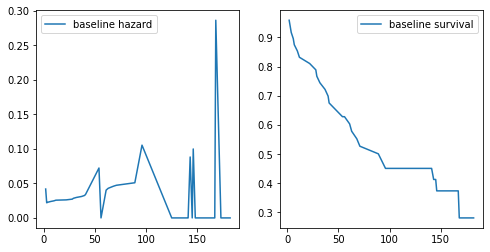

In [46]:
# Import CoxPHFitter class
from lifelines import CoxPHFitter

# Instantiate CoxPHFitter class cph
cph = CoxPHFitter()

# Fit cph to data
cph.fit(
    df=data,
    duration_col="T",
    event_col="E",
    formula='PRED',
)

# Baseline hazard and survival functions
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
cph.baseline_hazard_.plot(ax=axes[0])
cph.baseline_survival_.plot(ax=axes[1]);

The summary of the Cox test shows:

* Coef: x
* Hazard ratio: exp(x)
* Hazard interpretation: exp(x) - 1
* Survival time interpretation: 1/exp(x) - 1

1 unit increase in covariate from its median value -> hazards change by a factor of exp(coef) compared to baseline hazards

In [47]:
#cph.print_summary() # print strange LaTeX patterns in notebook...
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
PRED,-0.830606,0.435785,0.397304,-1.609307,-0.051905,0.200026,0.949419,-2.090606,0.036563,4.773457


In [48]:
print(cph.check_assumptions(
    training_df=data,
    p_value_threshold=.05)) # default 0.01

Proportional hazard assumption looks okay.
[]


C:\Users\WIECKOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\lifelines\fitters\mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  for variable in self.params_.index & (columns or self.params_.index):


For the example data, the hazard ratio is 0.436, with a 95% CI ranging from 0.200 to 0.949. In other words, the treated patients are dying at 43.6% of the rate of control patients, meaning that on any particular day or week, a treated patient has 43.6% of the chance of dying as a control patient.

If the two survival curves are identical, the HR would equal 1.0. Because the 95% CI of the sample data does not include 1.0, we can be at least 95% certain that the two populations have different survival experiences.

Of note, the log-rank and Mantel-Haenszel tests are almost the same, only differing in how they deal with multiple deaths at exactly the same time point.

### The Weinbull model

his class implements a Weibull model for univariate data. The model has parameterized form:

$$S(t)=\exp(-(\frac{t}{\lambda})^\rho), \lambda>0, \rho>0$$

The $\lambda$ (scale) parameter has an applicable interpretation: it represents the time when 63.2% of the population has died. The $\rho$ (shape) parameter controls if the cumulative hazard (see below) is convex or concave, representing accelerating or decelerating hazards.

The cumulative hazard rate is $H(t)=(\frac{t}{\lambda})^\rho$, and the hazard rate is $h(t)=\frac{\rho}{\lambda}(\frac{t}{\lambda})^{\rho-1}$, i.e.

* $\rho<1$: event rate decreases over time
* $\rho=1$: event rate constant
* $\rho>1$: event rate increases over time

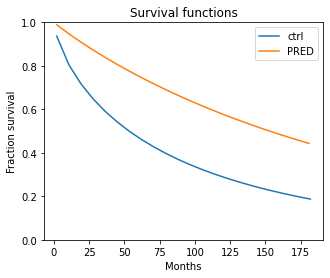

In [49]:
# Import WeibullFitter class
from lifelines import WeibullFitter

# Instantiate WeibullFitter class wb
wb = WeibullFitter()

# Fit data to wb
wb.fit(
    durations=data[~pred]['T'],
    event_observed=data[~pred]['E'],
    label='ctrl',
)

# Plot survival function
ax = wb.survival_function_.plot()


# Same for the other group
wb.fit(
    durations=data[pred]['T'],
    event_observed=data[pred]['E'],
    label='PRED',
)
wb.survival_function_.plot(ax=ax)

plt.title(f"Survival functions")
plt.xlabel("Months")
plt.ylim((0,1))
plt.ylabel("Fraction survival");

In [50]:
print(f"Some additional statistics for the group {wb._label}:\n")
print(wb.lambda_, wb.rho_, '\n')
print(1 - wb.predict(wb.lambda_))
wb.summary

Some additional statistics for the group PRED:

224.71810688719324 0.954520111234343 

0.6321205588285577


,coef,se(coef),coef lower 95%,coef upper 95%,z,p,-log2(p)
lambda_,224.718107,79.366302,69.163013,380.273201,2.818805,0.004820,7.696666
rho_,0.954520,0.268709,0.427860,1.481180,-0.169253,0.865597,0.208232


### Weibull model with covariates - survival regression

If/how one/multiple continuous variables affect survival function $Y_i = f(X_i,b)$ with $X_i$ the covariates, we use the **Accelerated Failure Time (AFT) model** summarized as $S_A(t) = S_B(t \times \lambda)$, where $\lambda(x) = \exp(\beta_0 + \beta_1 x_1 + ... + \beta_n x_n)$, and optionally $\rho(y) = \exp(\alpha_0 + \alpha_1 y_1 + ... + \alpha_n y_n)$ so that $ S(t;x,y) = \exp(-(\frac{t}{\lambda(x)})^{\rho(y)})$.

With no covariates, the Weibull model's parameters has the following interpretations: The $\lambda$ (scale) parameter has an applicable interpretation: it represent the time when 37% of the population has died. The $\rho$ (shape) parameter controls if the cumulative hazard (see below) is convex or concave, representing accelerating or decelerating hazards.

The cumulative hazard rate is $H(t;x,y) = (\frac{t}{\lambda(x)})^\rho(y)$

In [51]:
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter()

aft.fit(
    df=data,
    duration_col='T',
    event_col='E',
    formula='PRED + 0', # use of custom model with formula
)

aft.summary

coef  exp(coef)  se(coef)  coef lower 95%  \
param   covariate                                                  
lambda_ Intercept  4.481141  88.335371  0.316863        3.860100   
        PRED       1.054448   2.870390  0.509614        0.055622   
rho_    Intercept -0.236890   0.789078  0.168801       -0.567734   

                   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
param   covariate                                                             
lambda_ Intercept        5.102181            47.470097           164.380069   
        PRED             2.053274             1.057198             7.793372   
rho_    Intercept        0.093954             0.566808             1.098509   

                           z             p    -log2(p)  
param   covariate                                       
lambda_ Intercept  14.142189  2.086898e-45  148.425404  
        PRED        2.069110  3.853575e-02    4.697659  
rho_    Intercept  -1.403367  1.605075e-01    2.639287

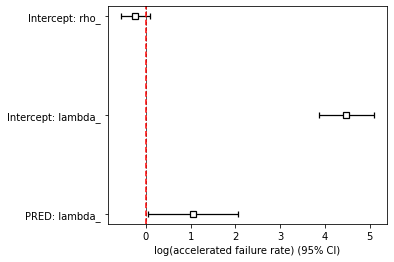

In [52]:
aft.plot()
plt.axvline(0, linestyle='--', color='red');

It is then possible to play further with the predicted objects, e.g. to plot partial effects for new individuals

```python
cph.plot_partial_effects_on_outcome(
    covariates=['fin', 'age', 'wexp', 'mar', 'paro', 'prio'],
    values=[
        [0, 35, 0, 1, 1, 3],
        [1, 22, 0, 0, 0, 0]])
```

And to plot the survival function with a given set of value for covariates as in the following example.

In [54]:
# data from the MOOC 'Introduction à la statistique avec R'

alcohol = pd.read_csv(
    "https://raw.githubusercontent.com/sbwiecko/intro_statistique_R/master/data/alcool.csv",
    delimiter=';',
)

alcohol.head()

,t,SEVRE,AGE,SEXE,EDVNEG
0,121,0,53,1,0
1,121,0,52,2,0
2,40,0,45,2,0
3,39,0,48,1,1
4,66,0,45,1,0


   test_statistic         p  -log2(p)
0        0.023537  0.878069  0.187594


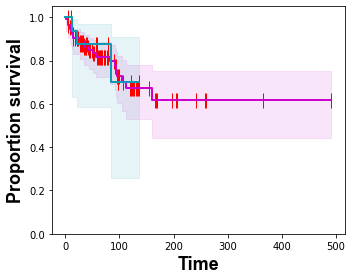

In [55]:
surv_ = alcohol[['t', 'SEVRE', 'SEXE', 'AGE']]

# survival analysis as a function of sex
ix = surv_['SEXE'] == 1

kmf2 = KaplanMeierFitter()

#plt.rcParams["figure.figsize"] = (6,4)

kmf2.fit(surv_['t'][ix], surv_['SEVRE'][ix])
ax=kmf2.plot(legend=None, show_censors=True, ci_alpha=.1, lw=2, c="#CC00CC",
              censor_styles={'marker':'|', 'ms': 15, 'mew':1, 'markerfacecolor':'red', 
                             'markeredgecolor': 'red'})

kmf2.fit(surv_['t'][~ix], surv_['SEVRE'][~ix])
kmf2.plot(ax=ax, legend=None, show_censors=True, ci_alpha=.1, lw=2, c="#0F99B2",
              censor_styles={'marker':'|', 'ms': 15, 'mew':1, 'markerfacecolor':'red', 
                             'markeredgecolor': 'red'},)

plt.ylabel('Proportion survival', fontdict={'fontname':'arial', 'size': 18, 'weight': 'bold'})
plt.ylim([0,1.05])
#plt.yticks(fontsize=16)

#plt.setp(ax.spines.values(), linewidth=2)
plt.xlabel('Time', fontdict={'fontname':'arial','size': 18, 'weight': 'bold'})

plt.tight_layout()

from lifelines.statistics import logrank_test
results = logrank_test(surv_['t'][ix], surv_['t'][~ix],
                      surv_['SEVRE'][ix], surv_['SEVRE'][~ix])
print(results.summary)

The P value was 0.878, so the difference between the two survival curves was not considered to be statistically significant. Next we do a more sophisticated analysis that adjusts for differences in age, sexe etc.

In [56]:
cph2 = CoxPHFitter()
cph2.fit(alcohol, duration_col='t', event_col='SEVRE')
cph2.print_summary()

<lifelines.CoxPHFitter: fitted with 125 total observations, 98 right-censored observations>
             duration col = 't'
                event col = 'SEVRE'
      baseline estimation = breslow
   number of observations = 125
number of events observed = 27
   partial log-likelihood = -113.28
         time fit was run = 2021-08-12 14:03:50 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
AGE        -0.05       0.95       0.02            -0.09            -0.00                 0.91                 1.00
SEXE       -0.02       0.99       0.62            -1.23             1.20                 0.29                 3.32
EDVNEG     -0.44       0.64       1.02            -2.45             1.56                 0.09                 4.78

              z    p   -log2(p)
covariate                      
AGE       -2.00 0.05       4.46
SEXE      -0.02 0.98       0.03
EDVNEG    -0.43 0.67       0.59
---
Concordance = 0.63
Partial AIC = 232.56
log-likelihood ratio test = 4.31 on 3 df
-log2(p) of ll-ratio test = 2.12

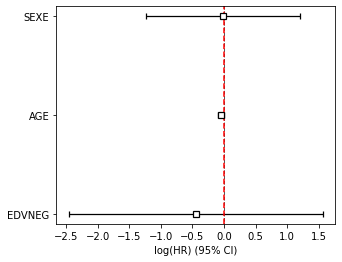

In [57]:
cph2.plot()
plt.axvline(0, linestyle='--', color='red');

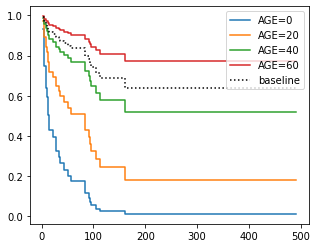

In [60]:
cph2.plot_partial_effects_on_outcome('AGE', [0, 20, 40, 60]);

### Other parametric model fitters

In [61]:
# Instantiate each fitter
from lifelines import WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter, GeneralizedGammaFitter
from lifelines.plotting import qq_plot

wb =  WeibullFitter()
exp = ExponentialFitter()
log = LogNormalFitter()
llg = LogLogisticFitter()
glm = GeneralizedGammaFitter()

# Fit to data
for model in [wb,exp,log,llg,glm]:
    model.fit(
        durations=data[pred]['T'],
        event_observed=data[pred]['E'],
    )
   
    print(model.__class__.__name__, model.AIC_) # Print AIC
# Akaike Information Criterion (AIC) estimatator of prediction error and relative quality of statistical models

WeibullFitter 144.54091487803493
ExponentialFitter 142.56870858109932
LogNormalFitter 146.80469733430616
LogLogisticFitter 145.8274267786253
GeneralizedGammaFitter 145.1976063744454


In [62]:
# Automate AIC comparisons btw parametric models (lifelines built-in)
from lifelines.utils import find_best_parametric_model

best_model, best_aic_ = find_best_parametric_model(
    event_times=data[pred]['T'],
    event_observed=data[pred]['E'],
    scoring_method="AIC"
)
print(best_model, best_aic_)

<lifelines.PiecewiseExponentialFitter:"PiecewiseExponentialFitter: 1 breakpoint", fitted with 22 total observations, 11 right-censored observations> 142.3526366699705
